In [2]:
import qmcpy as qp
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt
import scipy

print('okay')

okay


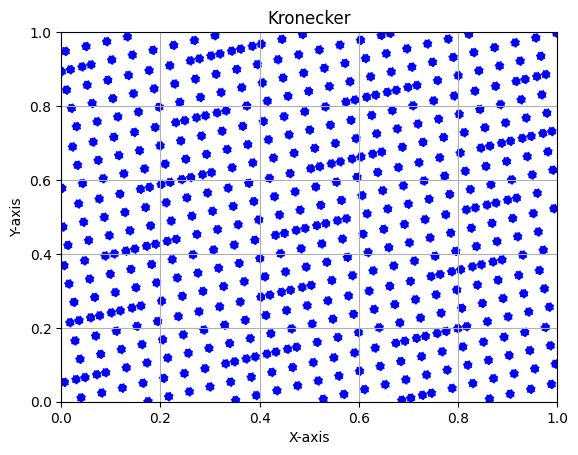

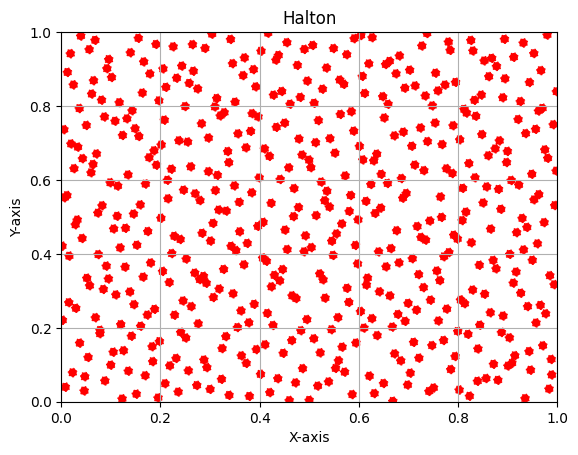

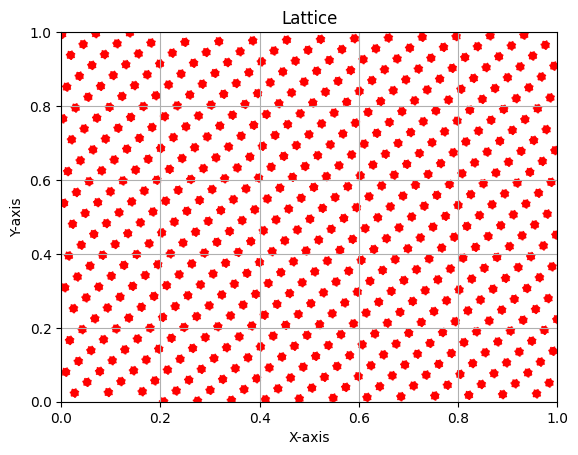

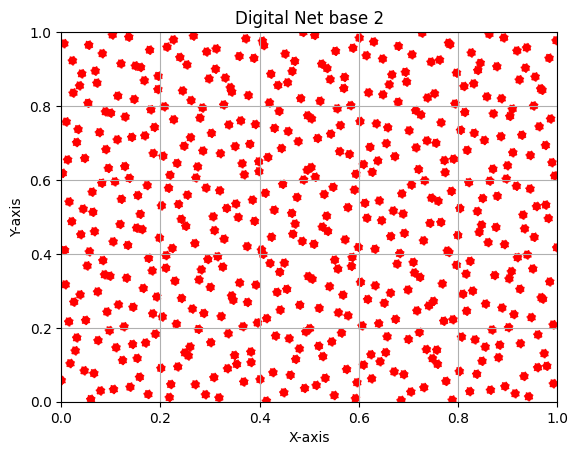

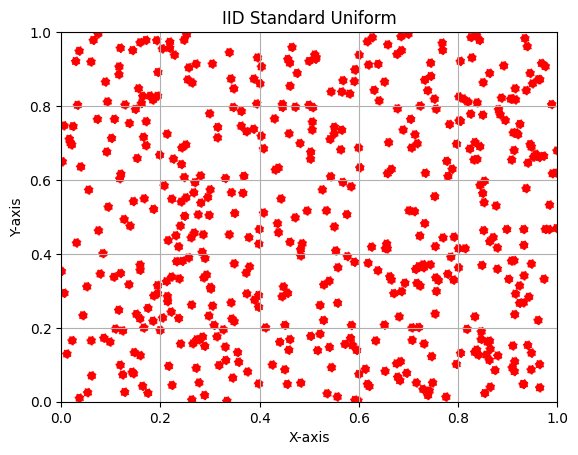

In [2]:
X = qp.kronecker(512, 2, alpha = [np.sqrt(2), np.sqrt(5)])
x = X[:,0]
y = X[:,1]

halton = qp.Halton(2)
H = halton.gen_samples(512)

lattice = qp.Lattice(2)
L = lattice.gen_samples(512)

dnb2 = qp.DigitalNetB2(2)
d2 = dnb2.gen_samples(512)

dd = qp.IIDStdUniform(2)
iid = dd.gen_samples(512)

# Create a line plot
plt.scatter(x, y, color='blue', linestyle='dotted')
plt.title('Kronecker')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(H[:,0], H[:, 1], color='red', linestyle='dotted')
plt.title('Halton')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(L[:,0], L[:, 1], color='red', linestyle='dotted')
plt.title('Lattice')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(d2[:,0], d2[:, 1], color='red', linestyle='dotted')
plt.title('Digital Net base 2')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

plt.scatter(iid[:,0], iid[:, 1], color='red', linestyle='dotted')
plt.title('IID Standard Uniform')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axis((0, 1, 0, 1))
plt.grid(True)
plt.show()

This cell above is to compare different sequences with the Kronecker sequences. By using Halton, Lattice, Digital Net base 2, and iid sequences, I wanted to see how they behave versus Kronecker sequences. We see that Kronecker sequence is a lot like Lattice sequence. The difference between both sequences is that Lattice sequence has to have a $2^n$ for $n \in \mathbb{N}$ number of samples, while Kronecker can have $n \in \mathbb{N}$ number of samples. Matter of fact, if we choose $\boldsymbol{\alpha}$ as $\boldsymbol{h} \phi_b(i)$, where $\phi_b$ is the van der Corput sequence in base b,  this wouldgive us  lattice sequence. Notice, closely related they are compared to other sequences like iid, Halton, or Digital Net Base 2.

In [62]:
def wtdsumsqdisckron(alphamat, n = 50, Time = False, limiter = 2**10, discwt = None,coordwts = np.arange(1,51).reshape((50, 1))):
    start_time = time.time()
    d, n_al = alphamat.shape
    #Use numpy's shape function to find dimension d and the different number of samples for alpha in [0,.5)^d
    coordwts = coordwts[0:d]
    #Makes sure we don't have extra values for coordinate weights
    if discwt == None:
        Discwt = np.arange(1,n+1).reshape((n, 1))
        #If discwt was not specified. Go ahead with the calculation.
    else:
        Discwt = discwt(n)
    #Need to find beta, which is to take the sum of Discwt.
    beta = np.sum(Discwt)
    squared = (np.arange(1,n+1).reshape((n, 1)))**2 
    #To find bhat, for each element take Discwt / squared.
    bhat = Discwt / squared
    #Unlike Matlab, in python to reverse the order of bhat, we have to use np.flip
    #As python's cumsum is different from Matlab's cumsum, as 1 goes 1 way while
    #the other goes in the opposite direction which is why I flipped it again.
    btilde = np.cumsum(np.flip(bhat))
    btilde = np.flip(btilde)
    #Use np.squeeze to minimize the size of btilde and to do the np.flip appropraiately
    A = np.flip(np.squeeze(btilde))
    A[1:n] = A[0:n-1]
    A[0] = 0
    #For the 3 lines of code above, when playing with the matlab code, you shift each element in the array
    #by 1 towards the end. However, the first element must be 0.
    btilde = A + np.flip(np.squeeze(bhat))
    b = np.flip(np.cumsum(btilde))
    #To calculate b, you have to use cumsum and then flip it due to the fact that it's not in the right
    #order based off of the Matlab code while converting it
    xkron = kronecker(n, alphamat)
    #I had to redesign kronecker, so that it can deal with multiple choices of alpha.

    #We introduce a limiter so that the computer doesn't get overwhelmed and possibly get a faster runtime
    #iteration = int(limiter / (n * d)) + 1
    
    #To calculate the discrepancy, we have the kernel. And wssd, the 3rd line below is how you calculate discrepancy
    #kernelkron = np.prod((1 + (0.5*coordwts.reshape((1,d,1))*(abs(xkron - .5) + .5 - abs(xkron)))),1)
    kernelkron = np.prod((1 + (0.5*coordwts.reshape((1, d, 1))*(xkron*(xkron-1) + 1/6))),1)
    wssd = -1*beta
    wssd = wssd + b[0]*kernelkron[0,:] + 2*np.sum(b[1:n].reshape((n-1, 1))*kernelkron[1:n, :],0)
    #In case you are interested in runtime in seconds for future use if we want to fasten the runtime.
    end_time = time.time()
    past_kron = kernelkron
    if Time == True:
        total_time = end_time - start_time
        return [wssd,xkron,b, bhat, btilde, total_time]
    else:
        return [wssd,xkron,b, bhat, btilde]

The point of this function is to find the best possible choice for $\boldsymbol{\alpha}$ by choicing whichever one would give the least weighted sum squared discrepancy at which 
$$
WSSD = \widetilde{K}(0) b(0) + 2 \sum_{k=1}^{N-1} b(k) \widetilde{K}(k \boldsymbol{\alpha} \mod \boldsymbol{1}) - \beta_N \int_{[0,1]} \widetilde{K}(\boldsymbol{t})~d \boldsymbol{t}
$$

At which $\beta_N = \sum_{n=1}^N w_n$ and $b_N(k) = \sum_{k+1}^N \frac{w_n(n-k)}{n^2}$. Note, $b_N(k)$ can be rewritten as 
$$
b_N(k) = b_N(k+1) + \widetilde{b_N}(k+1) + \frac{w_{k+1}}{(k+1)^2}
$$ 
for $k = N-2, N-3, ..., 0$ where $\widetilde{b_N}(k+1) = \sum_{n=k+2}^N \frac{w_n}{n^2}$. Of course, $\widetilde{b_N}(N-1) = b_N(N-1) = \frac{w_n}{N^2}$ and 
$$
\widetilde{b_N}(k) = \sum_{n=k+1}^N \frac{w_n}{n^2} = \widetilde{b_N}(k+1) + \frac{w_{k+1}}{(k+1)^2}$. To compute $\hat{b}(k)$, let $\hat{b}(k) = \frac{w_k}{k^2}
$$

The parameters this function will take are:

i.) $alphamat$ - A $(d \times n_{\alpha})$ 2D matrix where $d$ is the dimensions of $\boldsymbol{\alpha}$ and $n_{\alpha}$ is the amount samples of $\boldsymbol{\alpha}$. And this is required.

ii.) $n$ - being the number of samples within the Kronecker sequence.

iii.) $Time$ - set True if you want to record runtime (s) and False if you don't.

iv.) $limiter$ - limiter is the parameter to keep the computer from running too many computations at once and be overwhelmed.

v.) $discwt$ - That is the $w_n$ for the equation we have above.

vi.) $coordwts$ - The weights for each coordinate for the Kernels.

As for what the function gives out:

i.) $wssd$ - This will give the weighted sum squared discrepancy for each choice of $\boldsymbol{\alpha}$. 

ii.) $xkron$ - This is a $(n \times d \times n_{\alpha})$ 3D matrix where the first dimension is based on the sequence per choice of $\boldsymbol{\alpha} \in [0,1]^d$. 

iii.) $b$ - From the equation to calculate $WSSD$, it will give you $b(k)$ for $k = 1, 2, 3, ..., N-1$.

iv.) $bhat$ - This will give out the $\hat{b}(k)$ as calculated from what we have above for $k = N, N-1, N-2, ..., 1$.

v.) $btilde$ - This will give you $\widetilde{b}(k)$ for $k = N-2, N-3, ..., 0$ for the weighted sum squared discrepancy.

vi.) $total~time$ - This will give you the total runtime in seconds.

In [63]:
def kronecker(n, alpha, delta = 0):
    #Redesigned kronecker function. Since the original is buggy
    #and could not handle the operations needed to do the task 
    #of finding the best choice of alpha in [0,.5)^d
    i = np.arange(n).reshape((n, 1, 1))
    return(((i*alpha) + delta)%1)   
    
    #in order to find the Kronecker sequence take integer i, multiply it by alpha, then
    #take modular 1, so that the vector is in [0,1)^d.

The Kronecker function gives a 3D Matrix in the shape of $(n \times d \times n_{\alpha})$ that generates a sequence of points using multiple choices of $\boldsymbol{\alpha} \in [0,1]^d$. Since to get Kronecker sequence, we have to calculate $\{ x_i = (i \boldsymbol{\alpha} + \Delta) \mod 1 \}$. Of course our paramter $alpha$ should be set such that
$$
alpha =
\begin{bmatrix}
\boldsymbol{\alpha}_1 & \boldsymbol{\alpha}_2 & \boldsymbol{\alpha}_3 & ... & \boldsymbol{\alpha}_{n_\alpha}
\end{bmatrix}
$$
At which for $\boldsymbol{\alpha}_j \in [0,1]^d$ for $j = 1, 2, 3, ..., n_\alpha$. We can rewrite $alphamat$ to be
$$
alpha = 
\begin{bmatrix}
\alpha_{(1,1)} & \alpha_{(1,2)} & \alpha_{(1,3)} & ... & \alpha_{(1,n_\alpha)}\\
\alpha_{(2,1)} & \alpha_{(2,2)} & \alpha_{(2,3)} & ... & \alpha_{(2,n_\alpha)}\\
\alpha_{(3,1)} & \alpha_{(3,2)} & \alpha_{(3,3)} & ... & \alpha_{(3,n_\alpha)}\\
... & ... & ... & ... & ... \\
\alpha_{(d,1)} & \alpha_{(d,2)} & \alpha_{(d,3)} & ... & \alpha_{(d, n_\alpha)}
\end{bmatrix}
$$

For $\alpha_{(i,j)} \in [0,1]$ for $i = 1, 2, 3, ..., d$. The parameter $delta$ is our shifting vector at which $\Delta \in [0,1]^d$. Our variable $n$ is the number of samples we want for the Kronecker sequence.

In [70]:
def alpha_generate(d, n_al, n, rd = None, Limit = 2**10, Discw = None, Coordw = np.arange(1,51).reshape((50, 1))):
    alphamat = np.zeros((d,n_al))
    #initializes all n_al alpha in d-dimensions with 0's in order to look at each possible alpha one by one,
    #instead of it being n_al^d choices. With the for loop below, we would be looking at n_al*d possible
    #choices for alpha.
    
    #rd serves as a randomization seed like in Halton, Lattice, and IID Uniform.
    total = 0
    for i in range(d):
        np.random.seed(rd)
        alphamat[i, :] = ((np.arange(n_al).reshape(1,n_al)+np.random.rand(1,n_al))/(2*n_al)).reshape((1, n_al))
        #Had it range from [0,.5)^d instead of [0,1)^d, because of the fact that if we choose alpha in [0,1)^d,
        #then we can show that by taking $1- alpha$ the discrepancy with the Bernoulli polynomial kernal stays
        #the same, so it would make better sense to choose alpha in [0,.5)^d.
        [wssd,xkron,b, bhat, btilde, runtime] = wtdsumsqdisckron(alphamat[0:i+1, :], n, Time = True, limiter = Limit, discwt = Discw, coordwts = Coordw)
        #Goes ahead and calculates discrepancy per choice of alpha in [0,.5)^d
        indice = np.argmin(wssd)
        #Finds the element with the smallest discrepancy, as finding the minimum is vital. However, we don't
        #need the minimum itself. Just the argmin out of the choices for n_al samples of alpha.
        alphabest = alphamat[i, indice]
        #Gets the best choice for alpha for that dimension and then in the line below, replaces all the 
        #elements in the i-th dimension with the chosen alphabest based upon the argmin algorithm.
        alphamat[i, :] = np.ones((1, n_al))*alphabest
        total = total + runtime
    return [alphamat[:,0], min(wssd), total]

The function alpha_generate is used to generate the best $\boldsymbol{\alpha} \in [0, .5]^d$. The reason why we have $[0, .5]^d$ instead of $[0,1]^d$, because based on our Kronecker Symmetric Theorem, replacing one of the elements from $\alpha_\ell$ to $1 - \alpha_\ell$ would not change our discrepancy. Which would mean that our search for $\boldsymbol{\alpha}$ is of a smaller volume. Of course, the mission in order to get our best $\boldsymbol{\alpha}$ is to find which of these choices generated is the minimum. We have the following parameters:

We have $d$ representing the number of dimensions for $\boldsymbol{\alpha}$ we want generated. The n_al is the amount of samples for $\boldsymbol{\alpha}$ we are using. The variable $n$ of course is the number of samples for the Kronecker sequence. I put in rd which is the random seed in case someone wants to get rid of a mistake; however, rd I left optional. The paramter Limit is for the wtdsumsqdisckron function to limit how many calculations to do since calculating wssd for each generated $\boldsymbol{\alpha}$ can overwhelm the computer. Discw is the discrepancy weights which is $w_n$ in the WSSD function we have earlier in this demo. Coordw is the coordinate weights for the Kernels.

The function itself will return the best possible $\boldsymbol{\alpha} \in [0, .5]^d$ for the Kronecker sequence. The variable min(wssd) gives out the minimum weighted sum squared discrepancy of the best possible $\boldsymbol{\alpha}$. Finally, the variable total will give you the runtime of finding the best choice for $\boldsymbol{\alpha}$. 

In [71]:
[alpha_choice, wssd, runtime] = alpha_generate(5, 5000, 1000, Coordw = np.array([1, 1/4, 1/9, 1/16, 1/25, 1/36])) 
#generates a choice for alpha in a [0,.5]^d hypercube
print(alpha_choice)
n = 1000
xkron = kronecker(n, alpha_choice)
Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
k = n- np.arange(n-1).reshape((n-1, 1)) -1

print(np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1))


#Choosing alpha to range from .2 to .45, since it seems that the best choice for alpha is in that region
#As we already concluded that by choosing alpha in [0,1)^d if we take 1 - alpha, the discrepancy does
#not change
#alphamat = np.zeros((d,n_al))
#for i in range(d):
#    alphamat[i, :] = (((np.arange(n_al).reshape(1,n_al)+np.random.rand(1,n_al))/(4*n_al))+.2).reshape((1, n_al))
#    [wssd,xkron,b, bhat, btilde] = wtdsumsqdisckron(alphamat, n, coordwts = np.array([1, 1, 1,1, 1,1]))
#    indice = np.argmin(wssd)
#    alphabest = alphamat[i, indice]
#    alphamat[i, :] = np.ones((1, n_al))*alphabest
#print(alphamat[:, 0])
#print(wssd)

[0.38192121 0.27859789 0.21173333 0.43370371 0.41437896]
0.003302801650731956


In [16]:
print(np.mean(group_range))
print(np.var(group_range))
print(np.mean(group_not))
print(np.var(group_not))
t_statistic, p_value = scipy.stats.ttest_ind(group_range, group_not, equal_var = False, alternative = 'greater')
print('p-value')
print(p_value)
t_statistic, p_value = scipy.stats.ttest_ind(group_range, group_not, equal_var = False)
print('p-value')
print(p_value)

38.452760829342765
0.6549349757654019
39.70712528882967
0.7929264160775249
p-value
1.0
p-value
8.522814766685168e-49


In [69]:
[alpha_choice, wssd, runtime] = alpha_generate(5, 5000, 1000, Coordw = np.array([1, 1/4, 1/9, 1/16, 1/25, 1/36])) #generates a 5 dimensional choice for alpha

x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
#I chose my x to be from 50 to 1000 in increments of 50 as they will represent the number of samples n
y_one = 1/x
#The 1/x is for O(n^{-1})
y_half = 1/np.sqrt(x)
#This 1/sqrt(x) is for O(n^{-.5})
dim_1 = np.array([])
dim_2 = np.array([])
dim_3 = np.array([])
dim_4 = np.array([])
dim_5 = np.array([])
#initializing dims 1 to 5 as they will be used to record discrepancy for n samples

for d in range(1,6):
    for n in range(50, 1001, 50):
        n_al = 5000
        alphamat = alpha_choice[:d]
            
        xkron = kronecker(n, alphamat)
        Kernel = np.prod((1 + (0.5*(xkron*(xkron-1) + 1/6))),2)
        k = n- np.arange(n-1).reshape((n-1, 1)) -1
            
        discrepancy = np.sqrt(np.sum((n*Kernel[0,:]) + (2*np.sum(k*Kernel[1:n,:],0)))*(n**(-2)) - 1)
        if d == 1:
            dim_1 = np.append(dim_1, discrepancy)
        elif d == 2:
            dim_2 = np.append(dim_2, discrepancy)
        elif d == 3:
            dim_3 = np.append(dim_3, discrepancy)
        elif d == 4:
            dim_4 = np.append(dim_4, discrepancy)
        elif d == 5:
            dim_5 = np.append(dim_5, discrepancy)

plt.figure()
plt.loglog(x, y_one, label = "O(n^-1)", linestyle = '--')
plt.loglog(x, y_half, label = "O(n^-.5)", linestyle = '--')
plt.loglog(x, dim_1, label = "Dimension 1")
plt.loglog(x, dim_2, label = "Dimension 2")
plt.loglog(x, dim_3, label = "Dimension 3")
plt.loglog(x, dim_4, label = "Dimension 4")
plt.loglog(x, dim_5, label = "Dimension 5")
plt.legend()
plt.show()


TypeError: alpha_generate() got an unexpected keyword argument 'Coordw'

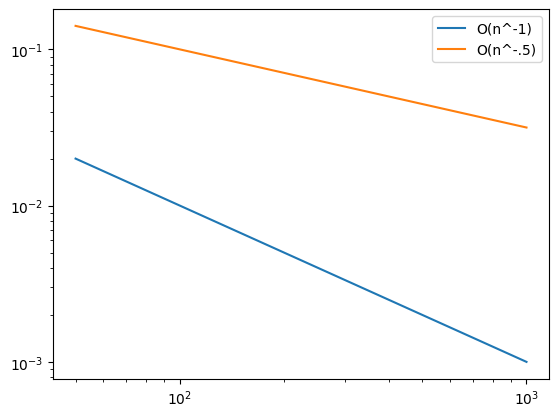

In [45]:
x = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000])
y_one = [1/50, 1/100, 1/150, 1/200, 1/250, 1/300, 1/350, 1/400, 1/450, 1/500, 1/550, 1/600, 1/650, 1/700, 1/750, 1/800, 1/850, 1/900, 1/950, 1/1000]
y_half = [50**(-.5), 100**(-.5), 150**(-.5), 200**(-.5), 250**(-.5), 300**(-.5), 350**(-.5), 400**(-.5), 450**(-.5), 500**(-.5), 550**(-.5), 600**(-.5), 650**(-.5), 700**(-.5), 750**(-.5), 800**(-.5), 850**(-.5), 900**(-.5), 950**(-.5), 1000**(-.5)]
plt.figure()
plt.loglog(x, y_one, label = 'O(n^-1)')
plt.loglog(x, y_half, label = 'O(n^-.5)')
plt.legend()
plt.show()

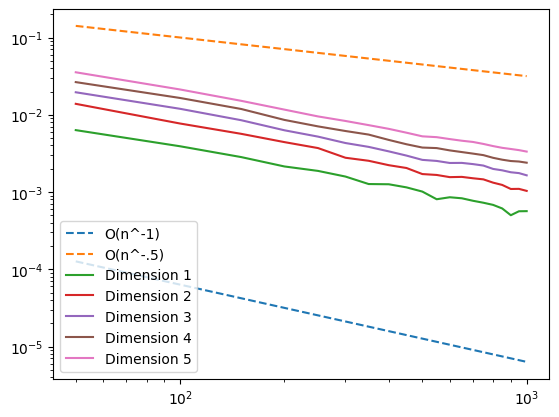

In [26]:
y_one = dim_1[0]*np.array(y_one)
plt.figure()
plt.loglog(x, y_one, label = "O(n^-1)", linestyle = '--')
plt.loglog(x, y_half, label = "O(n^-.5)", linestyle = '--')
plt.loglog(x, dim_1, label = "Dimension 1")
plt.loglog(x, dim_2, label = "Dimension 2")
plt.loglog(x, dim_3, label = "Dimension 3")
plt.loglog(x, dim_4, label = "Dimension 4")
plt.loglog(x, dim_5, label = "Dimension 5")
plt.legend()
plt.show()

In [68]:
X = np.log(np.array(x))
Y = np.log(np.array(dim_1))
m, b = np.polyfit(X, Y, 1)
print(m)

-0.9482858795107105


In [17]:
A = np.array([1, 2, 3, 4, 5])
print(A[:4])

[1 2 3 4]


In [36]:
n_al = 5
print(((np.arange(n_al).reshape(1,n_al)+np.random.rand(1,n_al))/(2*n_al)).reshape((1, n_al)))

[[0.00056512 0.14059333 0.24263363 0.3945106  0.45404466]]


In [64]:
d = 2
n_al = 10
alphamat = np.zeros((d,n_al))
print(alphamat)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
